# Data Bootcamp Final Project: Rural-Urban Inequality in Tanzania 
<br>
<br>

<div class="inline-block"> <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Flag_of_Tanzania.svg/1200px-Flag_of_Tanzania.svg.png" style="width: 200px;"/> </div> 

**Author: Michael Waugh**

**Email: [mwaugh@stern.nyu.edu](mwaugh@stern.nyu.edu)**

Poor countries have large masses of their population in rural, agriculture areas. Within these areas, [they earn and produce less relative to urban, non-agriculture areas](http://www.waugheconomics.com/uploads/2/2/5/6/22563786/apg.pdf). This observation begs the question: if people moved from rural to urban areas, would they reap gains in living standards. Or are the observed differences in livings standars simply and artifact of, say, differences in education or (unobserved) ability. This project uses the Tanzania LSMS dataset to document and understand rural-urban inequality.

This project will explore these issues in several steps:
1. I'll describe the data and its source 
2. Discuss the tools and packages that I will used to anaylze the data.
3. Primary Analysis
4. Extension to studying those that move.

## Data Report

The key elements of the data are from the [LSMS surveys](http://go.worldbank.org/IPLXWMCNJ0) from the [World Bank](http://www.worldbank.org/). The LSMS datasets are designed to measure living standards in countries where standard measurment apaparatuses (e.g. like the Census in the US) are not present. Access to the Tanzania dataset is free, but you must apply for access. The World Bank's website for the Tanzania LSMS dataset is here:

http://go.worldbank.org/EJMAC1YDY0

All data is stored in the `.dta` stata format. This is not a problem since we can use `pd.read_stata` command. There are many modules (sheets of data with different subject areas). Within each module there are the household responses and then a houshold id that can be used to link the responses across datasheets. I'm going to focus on only a couple of the datasets. The are discussed below:
- `TZY1.HH.Consumption.dta` and `TZY2.HH.Consumption.dta` is the consumption module in year one in 2008-2009 and the year two in 2011-2012 (?). The key element is that there is a "consumption aggregate" that reports aggregate expenditures by households. It also reports [adlut equivalents](https://en.wikipedia.org/wiki/Equivalisation), then per capita consumption within the houshold can be computed as the ratio of expenditures relative to adult equivalents. **This is the main variable of interest.** 
- Also within these data is the classification of households by if they live in a rural or urban area. This classification will be of interst as well as we examive differences in consumption by classification. 
- `HH.Geovariables_Y2.dta` is the geographic module that contains the coordinates of the household within year two. This will be used to map households locations and outcomes associated with those households.
- There is also an education module. This will be used to explore the role of differences in education or "human capital" in explaining rural-urban gaps in earnings. 

**Data Disclaimer:** Because this data is restricted access, I will pull the data directly from that saved on my local computer.

## My Packages

In the analysis below, I'm goint to use the following packages:
- `display` package which will display certain output in a nice way
- `Pandas` package which will be my core tool to import, manipulate, merge, and analyze the data
- `Matplotlib` package which will assiste me in ploting my results
- `numpy` which will allow me to perform certain mathimatical operations and transformations of the data (e.g. log of stuff). 
- `Basemap` which will allow me to map certain featurs of the data.
- `statsmodels` will allow me to perform regresion analysis on my data.

In [110]:
from IPython.display import display, Image # Displays things nicely
import pandas as pd # Key tool 
import matplotlib.pyplot as plt # Helps plot
import numpy as np # Numerical operations
from mpl_toolkits.basemap import Basemap # Basemap

import statsmodels.api as sm
import statsmodels.formula.api as smf

C:\Program Files\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Organize the Data

Below I walk through the steps to organize the data. I proceed by reading in the datasets, but only pull in the columns that I care about. I do this for the two years of consumption data, the geographic variables, and then the education data. I then merge the datasets together.

Below are the paths to the files on my local computers:

In [11]:
path_laptop = "C://Users//mwaugh//Dropbox//Panel Tracking Surveys//Tanzania//Raw Data (2008-2009 and 2010-2011)"
path_desktop = "C://Users//mwaugh.NYC-STERN//Dropbox//Panel Tracking Surveys//Tanzania\Raw Data (2008-2009 and 2010-2011)"

#### Bring in Year 1 Consumpiton Data

In [12]:
file = path_desktop + "//TZY1.HH.Consumption.dta"

myvars = ["hhid", "urban", "expmR", "adulteq", "hhsize", "hhweight", "region"]

tanz_y1 = pd.read_stata(file, columns = myvars)

tanz_y1.columns

new_name = []

for name in myvars:
    new_name.append(name + "_y1")
    
tanz_y1.columns = new_name

Then I want to create the consumption per adult equivalent measure and then lets look at the data.

In [13]:
tanz_y1["cons_y1"] = tanz_y1["expmR_y1"] / tanz_y1["adulteq_y1"]

display(tanz_y1.head(5))

,hhid_y1,urban_y1,expmR_y1,adulteq_y1,hhsize_y1,hhweight_y1,region_y1,cons_y1
0,01010140020171,Rural,1.730037e+06,4.52,5,5048.136719,Dodoma,382751.572895
1,01010140020284,Rural,4.539407e+05,2.28,3,5048.136719,Dodoma,199096.806365
2,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,896497.671583
3,01010140020409,Rural,1.523027e+06,2.84,4,5048.136719,Dodoma,536277.156015
4,01010140020471,Rural,1.416735e+06,3.52,5,5048.136719,Dodoma,402481.539679


#### Bring in Year 2 Consumption Data

In [14]:
file = path_desktop + "//TZY2.HH.Consumption.dta"

myvars = ["y2_hhid", "hhid_2008", "urban", "expmR", "adulteq", "hhsize", "hhweight", "region"]

tanz_y2 = pd.read_stata(file, columns = myvars)

new_name = []

for name in myvars:
    new_name.append(name + "_y2")
    
tanz_y2.columns = new_name


Then compute consumption per adult equivalent as well for year 2.

In [15]:
tanz_y2["cons_y2"] = tanz_y2["expmR_y2"] / tanz_y2["adulteq_y2"]

display(tanz_y2.head(5))

,y2_hhid_y2,hhid_2008_y2,urban_y2,expmR_y2,adulteq_y2,hhsize_y2,hhweight_y2,region_y2,cons_y2
0,0101014002017101,01010140020171,Rural,2453002.750,4.24,5,5152.955078,Dodoma,578538.383133
1,0101014002028401,01010140020284,Rural,1364008.375,2.76,4,5212.386719,Dodoma,494205.934679
2,0101014002029701,01010140020297,Rural,6136596.000,8.12,10,2564.016113,Dodoma,755738.420428
3,0101014002029704,01010140020297,Urban,3419913.000,6.36,8,3052.347412,Dar es Salaam,537722.171122
4,0101014002040901,01010140020409,Rural,1228936.250,4.16,6,5152.955078,Dodoma,295417.370159


Before we merge, lets look at the shape of each file so we completely understand what is going on.

In [16]:
print(tanz_y1.shape)
print(tanz_y2.shape)

(3265, 8)
(3846, 9)


**Two observations:**

- So the number of columns is different, this is because year two a 2008 household id and then a new id for 2012; hence the additional column.
- The number of rows is different. I suspect that the reason is that some housholds "broke up" in between the time periods. So in 2012, they are represented as a new additional houshold. 

One way to get a better understanding of this point is to look at how many unique 2008 household id's there are in the year two data set:

In [17]:
display(tanz_y2.hhid_2008_y2.unique().shape)

(3166,)

This is a bit surprising. What it looks like is two things going on. Some households are not connected across the sample; this may because they are unable to be found when conducting the year two data set, refused to participate, etc. Then there is the fact that year two has about 400 extra housholds why? This is an open quesiton.

#### Merge Year 1 and Year 2 

Now lets merge the datasets together on the 2008 hosehold id.

In [18]:
tanz = pd.merge(tanz_y1, tanz_y2, how='inner',
                         left_on = "hhid_y1", right_on = "hhid_2008_y2", indicator = True)

display(tanz.head(5))
display(tanz.shape)

,hhid_y1,urban_y1,expmR_y1,adulteq_y1,hhsize_y1,hhweight_y1,region_y1,cons_y1,y2_hhid_y2,hhid_2008_y2,urban_y2,expmR_y2,adulteq_y2,hhsize_y2,hhweight_y2,region_y2,cons_y2,_merge
0,01010140020171,Rural,1.730037e+06,4.52,5,5048.136719,Dodoma,382751.572895,0101014002017101,01010140020171,Rural,2453002.750,4.24,5,5152.955078,Dodoma,578538.383133,both
1,01010140020284,Rural,4.539407e+05,2.28,3,5048.136719,Dodoma,199096.806365,0101014002028401,01010140020284,Rural,1364008.375,2.76,4,5212.386719,Dodoma,494205.934679,both
2,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,896497.671583,0101014002029701,01010140020297,Rural,6136596.000,8.12,10,2564.016113,Dodoma,755738.420428,both
3,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,896497.671583,0101014002029704,01010140020297,Urban,3419913.000,6.36,8,3052.347412,Dar es Salaam,537722.171122,both
4,01010140020409,Rural,1.523027e+06,2.84,4,5048.136719,Dodoma,536277.156015,0101014002040901,01010140020409,Rural,1228936.250,4.16,6,5152.955078,Dodoma,295417.370159,both


(3846, 18)

Then I'm going to drop values if the merge did not work on both sides. I can check if this matters or not later.

In [19]:
display(tanz[tanz._merge == "both"].shape)

(3846, 18)

Looks like nothing was dropped. Future investigations should look at how the sample size is changing across years and understand exactly what is going on.

#### Merge with Year 2 Geography Variables

In [22]:
file = path_desktop + "//HH.Geovariables_Y2.dta"

geo_var = pd.read_stata(file, columns = ["y2_hhid", "lat_modified", "lon_modified"])


tanz = pd.merge(geo_var, tanz, how='inner',
                         left_on = "y2_hhid", right_on = "y2_hhid_y2")

display(tanz.head())

,y2_hhid,lat_modified,lon_modified,hhid_y1,urban_y1,expmR_y1,adulteq_y1,hhsize_y1,hhweight_y1,region_y1,...,y2_hhid_y2,hhid_2008_y2,urban_y2,expmR_y2,adulteq_y2,hhsize_y2,hhweight_y2,region_y2,cons_y2,_merge
0,0101014002017101,-5.08575,35.854389,01010140020171,Rural,1.730037e+06,4.52,5,5048.136719,Dodoma,...,0101014002017101,01010140020171,Rural,2453002.750,4.24,5,5152.955078,Dodoma,578538.383133,both
1,0101014002028401,-5.08575,35.854389,01010140020284,Rural,4.539407e+05,2.28,3,5048.136719,Dodoma,...,0101014002028401,01010140020284,Rural,1364008.375,2.76,4,5212.386719,Dodoma,494205.934679,both
2,0101014002029701,-5.08575,35.854389,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,...,0101014002029701,01010140020297,Rural,6136596.000,8.12,10,2564.016113,Dodoma,755738.420428,both
3,0101014002029704,-5.08575,35.854389,01010140020297,Rural,7.136122e+06,7.96,10,5048.136719,Dodoma,...,0101014002029704,01010140020297,Urban,3419913.000,6.36,8,3052.347412,Dar es Salaam,537722.171122,both
4,0101014002040901,-5.08575,35.854389,01010140020409,Rural,1.523027e+06,2.84,4,5048.136719,Dodoma,...,0101014002040901,01010140020409,Rural,1228936.250,4.16,6,5152.955078,Dodoma,295417.370159,both


## Aggregate, Cross-Sectional Analysis

Below, I first describe some summary statistics of the data focusing on the cross-sectional dimension. That is only within one year.

#### Consumption Data

I'm going to first look at the level of consumption in each year and then look at consumption growth across the years. So first, the level of consumption.

In [63]:
convert_to_dollars = 0.0004455530 # For December 2008 (seems stable)

y1sum = (tanz.cons_y1*convert_to_dollars).describe()

y2sum = (tanz.cons_y2*convert_to_dollars).describe() # Each of these are a series

sum_data = pd.concat([y1sum, y2sum], axis = 1) # Then use the concat method to create a dataframe
                                               # Which will give a nice visualization of the table
display(sum_data)

,cons_y1,cons_y2
count,3839.000000,3838.000000
mean,331.580256,390.151393
std,322.710943,354.803545
min,20.761887,32.411519
25%,151.305534,181.533352
50%,231.436136,280.455998
75%,385.517895,465.369968
max,6772.997294,3631.400641


A couple of things to note:
- So about 4000 households. Note how it looks like there are two less in year 2. Might want to investigate this at some point.
- On average, mean consumption increased. We will discuss this below. 
- Very poor. Average level of consumption is between 300 and 400 USD. Need to verify the time frame it covers, but no matter what this is poor, e.g. I spend that much on coffee and beer in a month probably. 
- Also, it looks like the dispersion is similar across the two years. Might want to do this is logs to verify. Latter we will visually inspect this.

Following up on a point made above: How much consumption growth was there? There are several different ways to get at this. What I will do is compute consumption growth at the household level, then report summary statistics for them. 

In [64]:
tanz["cons_growth"] = 100*(np.log(tanz.cons_y2) - np.log(tanz.cons_y1))

display(pd.DataFrame(tanz.cons_growth.describe()))

,cons_growth
count,3838.000000
mean,17.142055
std,61.781567
min,-256.092485
25%,-21.449128
50%,16.335116
75%,54.500076
max,281.055002


Key observation: **Average consumption growth was 17 percent over four years**. A quick google search suggests this is not inconsistent with national growth rates of GDP.  Also note the dispersion: Some households experienced large disasters. For example, a household in the 25th percentile experienced a **-21** percent drop in consumption. 

#### Rural Urban Status

Now lets examine the fraction of the households by rural or urban status. The first step to do this is I want to be able to perform a numerical calculation on the catagorical status of Rural or Urban. To do so, I need to use the `np.where` operation to compute it:

In [65]:
tanz["num_urban_y1"] = np.where(tanz["urban_y1"] == "Rural", 1, 0) # Creates a numerical catagorication of one or zero base on 
                                                                   # rural or ubran status
tanz["num_urban_y2"] = np.where(tanz["urban_y2"] == "Rural", 1, 0) # for year two

Then lets report some descriptive statistics.

In [66]:
y1sum = tanz.num_urban_y1.describe()
y2sum = tanz.num_urban_y2.describe()

sum_data = pd.concat([y1sum, y2sum], axis = 1) # Then use the concat method to create a dataframe
                                               # Which will give a nice visualization of the table

display(sum_data.loc[["count","mean"]]) #Only show the count and the mean

,num_urban_y1,num_urban_y2
count,3839.000000,3839.00000
mean,0.643918,0.67231


Key observation: **In year one and year two about 60+ percent of the housholds live in rural areas.** Note that it appears that the fraction of rural housholds actually increased in year two. The one issue with this is that these are simple means and not using the sampling weights that are provided. Should update in the future.

#### Rural Urban Gaps in Living Standards

The final point is to report differences in living standard between rural and urban areas. 

In [62]:
cons_gap_mean = (tanz[(tanz["urban_y1"]== "Urban") & ( tanz["urban_y1"]== "Urban")].cons_y1.mean()/
                 tanz[(tanz["urban_y1"]== "Rural") & ( tanz["urban_y1"]== "Rural")].cons_y2.mean())  

cons_gap_median = (tanz[(tanz["urban_y1"]== "Urban") & ( tanz["urban_y1"]== "Urban")].cons_y1.median()/
                 tanz[(tanz["urban_y1"]== "Rural") & ( tanz["urban_y1"]== "Rural")].cons_y2.median())

cons_gap_mean_y2 = (tanz[(tanz["urban_y2"]== "Urban") & ( tanz["urban_y2"]== "Urban")].cons_y1.mean()/
                 tanz[(tanz["urban_y2"]== "Rural") & ( tanz["urban_y2"]== "Rural")].cons_y2.mean())  

cons_gap_median_y2 = (tanz[(tanz["urban_y2"]== "Urban") & ( tanz["urban_y2"]== "Urban")].cons_y1.median()/
                 tanz[(tanz["urban_y2"]== "Rural") & ( tanz["urban_y2"]== "Rural")].cons_y2.median())


sum_gaps = {"Year": ["2008", "2012"],
            "Mean" : [round(cons_gap_mean,3), round(cons_gap_mean_y2,3)],
            "Median" : [round(cons_gap_median,3), round(cons_gap_median_y2,3)],}

sum_gaps = pd.DataFrame(sum_gaps)

display(sum_gaps)

,Mean,Median,Year
0,1.784,1.668,2008
1,1.666,1.580,2012


Here what we see is that: rural areas earn substantially less than urban areas. In 2008, this was around 70 percent, shrinking slightly in 2012. 

This observation is consistent with prior research that finds large gaps. Moreover, note that this gap (from an accounting perspective) matters as most of the Tanzanian population is Rural. Thus, from a mechanical perspective...why is Tanzania really poor? Well most of their population is rural.

## Geographic Dimensions of Rural-Urban Inequality

Lets look at a couple of dimeionsons of rural-urban inequality. One is across the regions in Tanzania. Another is across unique geo-codes. In the analysis below, I'm going to focus on year 2 for several reasons. One is that Zanzibar appears to be miscoded with respect to urban-rural status. Second, Geocodes are all for year 2. So we will go with that.

### Rural-Urban Inequality By Region 

The idea her is to plot average consumption by region relative to their rural-urban share. Thus, this is exploiting the variation in different regions urbanization and exploring how their relative living standards all matches up. 

The first step to performing this analysis is to `groupby` on the region variable and then construct the appropriate variables.

In [133]:
year = "_y2"

grouped = tanz.groupby(("region" + year)) # Groupby region and year

avg_reg_cons = grouped["expmR" + year].sum() / grouped["adulteq"+ year].sum() # Average consumption 

avg_reg_cons = avg_reg_cons/avg_reg_cons.mean() # Normalize it relative to the aggregate mean

frac_rural = grouped["num_urban" + year].mean() # regional rural urbanization

frac_urban = 1-frac_rural

size = 0.50*grouped["hhweight"+ year].mean() # How important different regions are

Then I'm going to regress consumption on the urban share of each region. The reason I'm doing this is so I can generate a best fit line plot on top of our scatter plot. After the discussion of the graph, I'll discuss the results as well.

In [134]:
data = pd.concat([avg_reg_cons, frac_urban], axis = 1) # Create a dataframe

data.columns = ["avg_reg_cons", "frac_urban"] # rename the columns so this makesense

results = smf.ols('''avg_reg_cons ~ frac_urban''', 
                  data= data).fit()  # Then use stats models to estimate the linear relationship

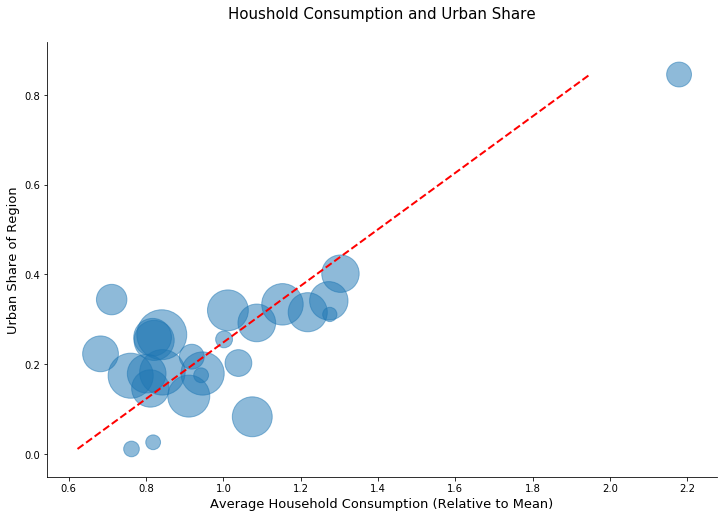

In [171]:
fig, ax = plt.subplots(figsize = (12,8))

ax.scatter(data.avg_reg_cons, data.frac_urban, s = size, alpha = 0.50)

ax.set_title("Houshold Consumption and Urban Share\n", fontsize = 15)
ax.set_ylabel("Urban Share of Region", fontsize = 13) 
ax.set_xlabel("Average Household Consumption (Relative to Mean)", fontsize = 13)

##### Now plot the best fit line

pred = results.predict(exog = data["frac_urban"].sort_values())

ax.plot(pred, data["frac_urban"].sort_values(),
        color = 'r', linewidth = 2.0, linestyle = "dashed", label = "Best Fit Line")

##### Make it look nice

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

The figure shows a very clear, systematic relationship between consumption and the Urban Share of a region. If we look closely, the outlier in the upper-right hand corner is Dar Es Salam, i.e. the major urban center of Tanzania. 

What to make of this? Urbanization seems to matter a lot. A way to get a more formal sense of this is to look at the statistics from the regression:

In [174]:
display(results.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           avg_reg_cons   R-squared:                       0.678
Model:                            OLS   Adj. R-squared:                  0.665
Method:                 Least Squares   F-statistic:                     50.57
Date:                Wed, 13 Dec 2017   Prob (F-statistic):           2.37e-07
Time:                        13:58:43   Log-Likelihood:                 9.5959
No. Observations:                  26   AIC:                            -15.19
Df Residuals:                      24   BIC:                            -12.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6050      0.065      9.279      0.000       0.470       0.740
frac_urban     1.5887      0.223      7.111      0.000       1.128       2.050
==============================================================================
Omnibus:                        2.220   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.330   Jarque-Bera (JB):                1.165
Skew:                          -0.499   Prob(JB):                        0.559
Kurtosis:                       3.281   Cond. No.                         6.96
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Where we see that the **Urban share explains almost 70 percent of the variation in consumption.** And this is all within Tanzania variation. One interesting question to follow up on would be to look at the cross-country evidence: For example, how much variation in cross-country income inequality is explained by the urban share. And is the slope, similar to the within country evidence?

### Rural-Urban Inequality by Household Location

This section esentially delves deeper into the region component by looking at the specific location of the household (which we have) and their level of consumption. Again, to execute this, I will `groupby` on the latitude and longitude of their reported location and then map their status as rural or urban, and map the associated level of consumption.

Step one: Groupby the location.

In [225]:
tanz["rural_y2"] = 1-tanz["num_urban_y2"]

geo_group = tanz.groupby(["lat_modified","lon_modified"])

cnt = geo_group.agg({"cons_y2": "mean", "y2_hhid_y2": "count", "rural_y2": "mean"})

cnt.reset_index(inplace = True) # The issue is that the index is the group, lets reset it
                                # so I can get access to it.
    
display(cnt.head(5))

,lat_modified,lon_modified,rural_y2,cons_y2,y2_hhid_y2
0,-11.49701,35.607632,0.000000,397344.551492,9
1,-11.31545,34.786301,0.666667,766766.233372,9
2,-11.17032,34.996471,0.000000,443776.292471,10
3,-11.10879,34.642170,1.000000,530443.634563,10
4,-11.07245,37.319248,1.000000,499437.266714,10


Then here are some city locations from Tanzania. I found these on google by asking "latitude and longitude of X in Tanzania" where X is a city that I was aware of.

In [226]:
citylon = [39.20 , 40.1760, 35.7516, 32.9175, 36.6830]

citylat = [-6.79 , -10.3112, -6.1630, -2.5164,  -3.3869]

citylabels = ["Dar Es Salam", "Mtwara", "Dodoma", "Mwanza", "Arusha"]

# Some locations to put on this...

Then below is the mapping routine. A lot is going on, but the essential idea is (i) construct the map (ii) plot the housholds on the map and (iii) make it look nice. 

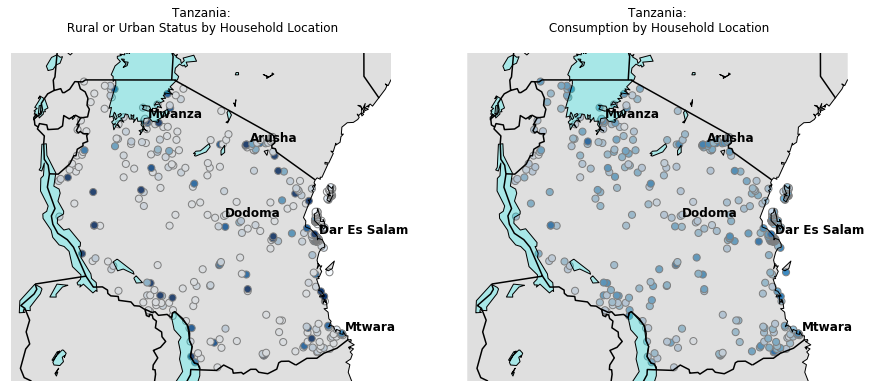

In [252]:
###########################################################################################

fig, ax = plt.subplots(1, 2, figsize = (15,15))

###########################################################################################

my_map = Basemap(projection='merc', # This is a simple one...some options require more input
                 resolution = 'l', area_thresh = 100.0, # Change ARC Thres, some islands don't show up.
                 llcrnrlon=28, llcrnrlat=-12, # This says "lower left hand cornoer lon, lower left hand corner lat
                 urcrnrlon=42, urcrnrlat=-0, ax = ax[0])  # This says upper right hand corner lon, upper right corner lat
                                              # Then it will draw a box given these specifications.

my_map.drawcoastlines()

my_map.drawcountries(linewidth=1.5) # Make the country lines bolder

my_map.fillcontinents(color='grey',alpha = 0.25,lake_color='aqua') # Fill in the lakes

x,y = my_map(cnt.lon_modified.tolist(), cnt.lat_modified.tolist())    

my_map.scatter(x,y, latlon = False, c = cnt.rural_y2.tolist(), cmap = plt.cm.Blues,
               s = 50, alpha = 0.99,  edgecolor='tab:gray')
    
###########################################################################################
# Add Labels

x,y = my_map(citylon, citylat) 

for label, xpt, ypt in zip(citylabels, x, y):
    
    ax[0].text(xpt+15000, ypt+15000, label,  weight = "bold",fontsize=12)

ax[0].set_title("Tanzania:\n Rural or Urban Status by Household Location\n")    
    
ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)    

###########################################################################################
###########################################################################################
# Lets put consumption next to it

my_map = Basemap(projection='merc', # This is a simple one...some options require more input
                 resolution = 'l', area_thresh = 100.0, # Change ARC Thres, some islands don't show up.
                 llcrnrlon=28, llcrnrlat=-12, # This says "lower left hand cornoer lon, lower left hand corner lat
                 urcrnrlon=42, urcrnrlat=-0,ax = ax[1])  # This says upper right hand corner lon, upper right corner lat
                                              # Then it will draw a box given these specifications.

my_map.drawcoastlines()

my_map.drawcountries(linewidth=1.5) # Make the country lines bolder

my_map.fillcontinents(color='grey',alpha = 0.25,lake_color='aqua') # Fill in the lakes

x,y = my_map(cnt.lon_modified.tolist(),cnt.lat_modified.tolist()) 

my_map.scatter(x,y, latlon = False, c = np.log(cnt.cons_y2.tolist()),
               cmap = plt.cm.Blues, s = 50, alpha = 0.99,  edgecolor='tab:gray')

###########################################################################################
# Add Labels

x,y = my_map(citylon, citylat) 

for label, xpt, ypt in zip(citylabels, x, y):
    
    ax[1].text(xpt+15000, ypt+15000, label, weight = "bold", fontsize=12)

ax[1].set_title("Tanzania:\n Consumption by Household Location\n")

ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

###########################################################################################
plt.show()

Let me explain this graph. So each dot is a (group) of households. On the left panel is there location, with lighter locations being rural, darker being urban (most are just one or zero, but there is some mix). Here you see that around Dar Es Salam, or Arusha, there are urban households.  On the right panel there is the consumption per adult equivalent at the household. Darker areas have higher levels of consumption.

The takeaway sit the urban areas in space, have higher levels of consumption. This is consistent with the aggregate facts above, the across region variation discussed in the plot above. And now here is a mapping illustrating the same point. 

### Tracking Households Across Time

Explore how income changes over time with rural urban status. Some tables and simple regression. Add in eduction.

## Summary

Summarize what I find